[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sakth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Raw Data (First 5 records) ===
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

=== After Label Encoding (First 5 records) ===
   Category                                            Message
0         1  Go until jurong point, crazy.. Available only ...
1         1                      Ok lar... Joking wif u oni...
2         0  Free entry in 2 a wkly comp to win FA Cup fina...
3         1  U dun say so early hor... U c already then say...
4         1  Nah I don't think he goes to usf, he lives aro...

=== Before Text Cleaning (First 5 Messages) ===
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Fr

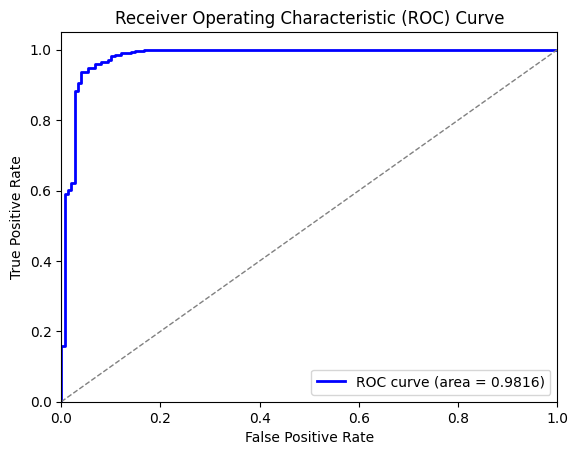


The message is classified as: Spam


In [2]:
  #final using logistic regression

  import nltk
  nltk.download('stopwords')
  import numpy as np
  import pandas as pd
  import re
  from nltk.corpus import stopwords
  from nltk.stem import PorterStemmer
  from sklearn.model_selection import train_test_split, GridSearchCV
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.linear_model import LogisticRegression
  from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
  import matplotlib.pyplot as plt
  from sklearn.pipeline import Pipeline
  from sklearn.preprocessing import StandardScaler

  # Load the dataset
  raw_mail_data = pd.read_csv('mail_data.csv')

  # 1. Display the first few records before any preprocessing
  print("\n=== Raw Data (First 5 records) ===")
  print(raw_mail_data.head())

  # Replace null values with an empty string
  mail_data = raw_mail_data.where(pd.notnull(raw_mail_data), '')

  # 2. Label encoding: spam as 0, ham as 1
  mail_data['Category'] = mail_data['Category'].map({'spam': 0, 'ham': 1}).astype(int)

  # Display after label encoding
  print("\n=== After Label Encoding (First 5 records) ===")
  print(mail_data.head())

  # Separate the data into texts (X) and labels (Y)
  X = mail_data['Message']
  Y = mail_data['Category']

  # Display first few messages before text cleaning
  print("\n=== Before Text Cleaning (First 5 Messages) ===")
  print(X.head())

  # Initialize the Porter Stemmer
  ps = PorterStemmer()

  # Initialize the set of English stopwords
  stop_words = set(stopwords.words('english'))

  # Function to preprocess text
  def preprocess_text(message):
      # Text Cleaning: Remove punctuation and convert to lowercase
      cleaned = re.sub(r'[^\w\s]', '', message.lower())

      # Tokenization: Split text into individual words
      words = cleaned.split()

      # Stop Words Removal: Remove common words
      filtered_words = [word for word in words if word not in stop_words]

      # Stemming: Reduce words to their root form
      stemmed_words = [ps.stem(word) for word in filtered_words]

      # Join the processed words back into a single string
      return ' '.join(stemmed_words), cleaned, words, filtered_words

  # Apply preprocessing to each message
  X_processed = X.apply(preprocess_text)

  # Convert tuple result to DataFrame
  X_df = pd.DataFrame(X_processed.tolist(), columns=['Final Text', 'Cleaned Text', 'Tokenized', 'After Stopword Removal'])

  # Display first 5 rows at each preprocessing step
  print("\n=== After Text Cleaning (First 5 Messages) ===")
  print(X_df[['Cleaned Text']].head())

  print("\n=== After Tokenization (First 5 Messages) ===")
  print(X_df[['Tokenized']].head())

  print("\n=== After Stopwords Removal (First 5 Messages) ===")
  print(X_df[['After Stopword Removal']].head())

  print("\n=== After Stemming (Final Processed Messages) ===")
  print(X_df[['Final Text']].head())

  # Final processed text
  X_final = X_df['Final Text']

  # Split the data into training and testing sets (80% train, 20% test)
  X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y, test_size=0.2, random_state=3, stratify=Y)

  # Define a pipeline combining TF-IDF vectorization, feature scaling, and logistic regression
  pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)),
      ('scaler', StandardScaler(with_mean=False)),
      ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
  ])

  # Define the hyperparameters to tune
  param_grid = {
      'classifier__C': [0.01, 0.1, 1, 10, 100],
      'classifier__solver': ['liblinear', 'saga']
  }

  # Initialize GridSearchCV with cross-validation
  grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

  # Fit the model
  grid_search.fit(X_train, Y_train)

  # Best parameters from grid search
  print(f'\nBest Parameters: {grid_search.best_params_}')

  # Predict on the test data
  test_predictions = grid_search.predict(X_test)
  test_probabilities = grid_search.predict_proba(X_test)[:, 1]

  # Evaluate the model
  accuracy = accuracy_score(Y_test, test_predictions)
  print(f'\nAccuracy: {accuracy:.4f}')

  conf_matrix = confusion_matrix(Y_test, test_predictions)
  print('\nConfusion Matrix:')
  print(conf_matrix)

  class_report = classification_report(Y_test, test_predictions, target_names=['Spam', 'Ham'])
  print('\nClassification Report:')
  print(class_report)

  # ROC Curve & AUC Score
  fpr, tpr, thresholds = roc_curve(Y_test, test_probabilities)
  roc_auc = roc_auc_score(Y_test, test_probabilities)
  print(f'\nROC AUC Score: {roc_auc:.4f}')

  # Plotting the ROC Curve
  plt.figure()
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
  plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

  # Function to classify new input messages
  def classify_message(message):
      # Preprocess the message
      processed_message, _, _, _ = preprocess_text(message)
      # Transform the message using the trained TF-IDF vectorizer
      transformed_message = grid_search.best_estimator_.named_steps['tfidf'].transform([processed_message])
      # Scale the transformed message
      scaled_message = grid_search.best_estimator_.named_steps['scaler'].transform(transformed_message)
      # Predict the category using the trained classifier
      prediction = grid_search.best_estimator_.named_steps['classifier'].predict(scaled_message)
      # Return 'Spam' or 'Ham' based on the prediction
      return 'Spam' if prediction[0] == 0 else 'Ham'

  # Example usage
  new_message = "Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now."
  print(f'\nThe message is classified as: {classify_message(new_message)}')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sakth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Raw Data (First 5 records) ===
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

=== After Label Encoding (First 5 records) ===
   Category                                            Message
0         1  Go until jurong point, crazy.. Available only ...
1         1                      Ok lar... Joking wif u oni...
2         0  Free entry in 2 a wkly comp to win FA Cup fina...
3         1  U dun say so early hor... U c already then say...
4         1  Nah I don't think he goes to usf, he lives aro...

=== Before Text Cleaning (First 5 Messages) ===
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Fr

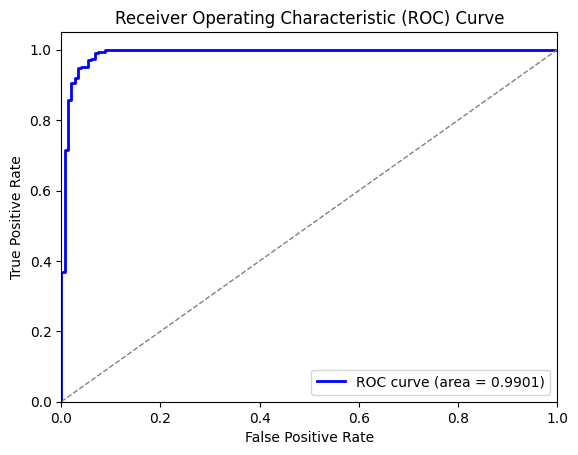


The message is classified as: Spam


In [4]:
#navie bais
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Load the dataset
raw_mail_data = pd.read_csv('mail_data.csv')

# 1. Display raw data
print("\n=== Raw Data (First 5 records) ===")
print(raw_mail_data.head())

# Replace null values with an empty string
mail_data = raw_mail_data.where(pd.notnull(raw_mail_data), '')

# 2. Label encoding: spam as 0, ham as 1
mail_data['Category'] = mail_data['Category'].map({'spam': 0, 'ham': 1}).astype(int)

# Display after label encoding
print("\n=== After Label Encoding (First 5 records) ===")
print(mail_data.head())

# Separate the data into texts (X) and labels (Y)
X = mail_data['Message']
Y = mail_data['Category']

# Display first few messages before text cleaning
print("\n=== Before Text Cleaning (First 5 Messages) ===")
print(X.head())

# Initialize the Porter Stemmer
ps = PorterStemmer()

# Initialize the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(message):
    # Text Cleaning: Remove punctuation and convert to lowercase
    cleaned = re.sub(r'[^\w\s]', '', message.lower())

    # Tokenization: Split text into individual words
    words = cleaned.split()

    # Stop Words Removal: Remove common words
    filtered_words = [word for word in words if word not in stop_words]

    # Stemming: Reduce words to their root form
    stemmed_words = [ps.stem(word) for word in filtered_words]

    # Join the processed words back into a single string
    return ' '.join(stemmed_words), cleaned, words, filtered_words

# Apply preprocessing to each message
X_processed = X.apply(preprocess_text)

# Convert tuple result to DataFrame
X_df = pd.DataFrame(X_processed.tolist(), columns=['Final Text', 'Cleaned Text', 'Tokenized', 'After Stopword Removal'])

# Display first 5 rows at each preprocessing step
print("\n=== After Text Cleaning (First 5 Messages) ===")
print(X_df[['Cleaned Text']].head())

print("\n=== After Tokenization (First 5 Messages) ===")
print(X_df[['Tokenized']].head())

print("\n=== After Stopwords Removal (First 5 Messages) ===")
print(X_df[['After Stopword Removal']].head())

print("\n=== After Stemming (Final Processed Messages) ===")
print(X_df[['Final Text']].head())

# Final processed text
X_final = X_df['Final Text']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y, test_size=0.2, random_state=3, stratify=Y)

# Define a pipeline combining TF-IDF vectorization and Naïve Bayes classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)),
    ('classifier', MultinomialNB())
])

# Define the hyperparameters to tune
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, Y_train)

# Best parameters from grid search
print(f'\nBest Parameters: {grid_search.best_params_}')

# Predict on the test data
test_predictions = grid_search.predict(X_test)
test_probabilities = grid_search.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(Y_test, test_predictions)
print(f'\nAccuracy: {accuracy:.4f}')

conf_matrix = confusion_matrix(Y_test, test_predictions)
print('\nConfusion Matrix:')
print(conf_matrix)

class_report = classification_report(Y_test, test_predictions, target_names=['Spam', 'Ham'])
print('\nClassification Report:')
print(class_report)

# ROC Curve & AUC Score
fpr, tpr, thresholds = roc_curve(Y_test, test_probabilities)
roc_auc = roc_auc_score(Y_test, test_probabilities)
print(f'\nROC AUC Score: {roc_auc:.4f}')

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Function to classify new input messages
def classify_message(message):
    # Preprocess the message
    processed_message, _, _, _ = preprocess_text(message)
    # Transform the message using the trained TF-IDF vectorizer
    transformed_message = grid_search.best_estimator_.named_steps['tfidf'].transform([processed_message])
    # Predict the category using the trained classifier
    prediction = grid_search.best_estimator_.named_steps['classifier'].predict(transformed_message)
    # Return 'Spam' or 'Ham' based on the prediction
    return 'Spam' if prediction[0] == 0 else 'Ham'

# Example usage
new_message = "Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now."
print(f'\nThe message is classified as: {classify_message(new_message)}')
